<b style="font-size:1.2vw">Problem Statement<b>

Access to safe drinking-water is essential to health, a basic human right and a component
of effective policy for health protection. This is important as a health and development issue
at a national, regional and local level. The objective is to predict the potability of water
based on given features.
The water_potability.csv file contains water quality metrics for 3276 different water bodies.

<b style="font-size:1.2vw">Import required libraries<b>

In [1]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV

<b style="font-size:1.2vw">Exploratory data analysis<b>

In [2]:
# reading the dataset in csv
df = pd.read_csv("water_potability.csv")

In [3]:
# printing first 2 rows for sanity check
df.head(2)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.71608,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0


In [4]:
# printing last 2 rows
df.tail(2)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1
3275,7.874671,195.102299,17404.177061,7.509306,NaN,327.459760,16.140368,78.698446,2.309149,1


In [5]:
# get dimenions of the dataset
df.shape

(3276, 10)

In [6]:
# getting the structure info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [7]:
# getting the statistical description of data
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


<p>Observation: For Solids mean is higher than median indicating that the data is slighly skewed<p>

In [8]:
# getting the null values present in the dataset
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

<p>Observation: Columns ph, Sulfate and Trihalomethanes have null/missing values.<p>

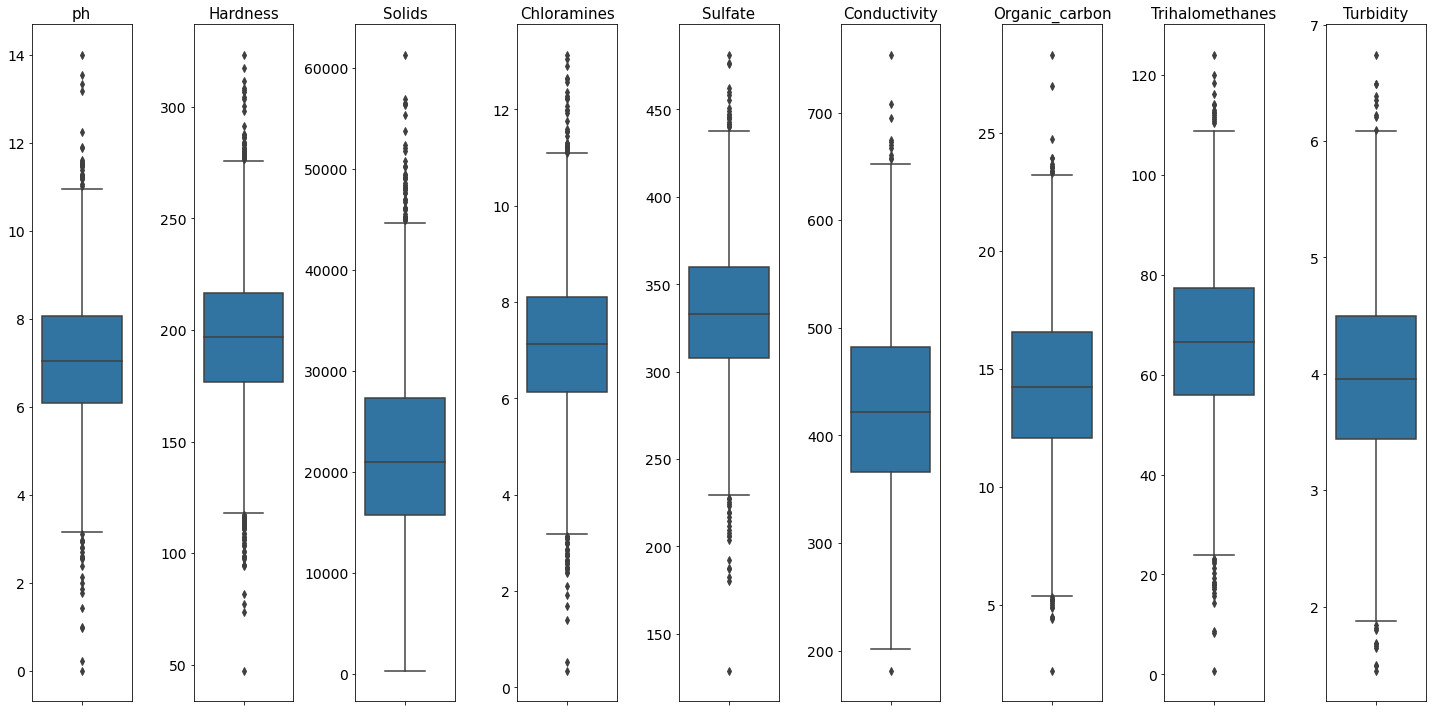

In [9]:
# checking for outliers for all features by plotting their boxplots
fig, axs = plt.subplots(1, len(df.columns)-1, figsize=(20,10))
for i, ax in enumerate(axs.flat): 
    sns.boxplot(y=df.iloc[:,i], ax=ax)
    ax.set_title(df.columns[i], fontsize=15)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('')
    
plt.tight_layout()

<p>Observation: All the featuers has outliers deeming the outliers normal. As logistic regression gets affected by strong outliers, they need to be handled but with minimum data loss<p>

<b>Correlation Analysis<b>

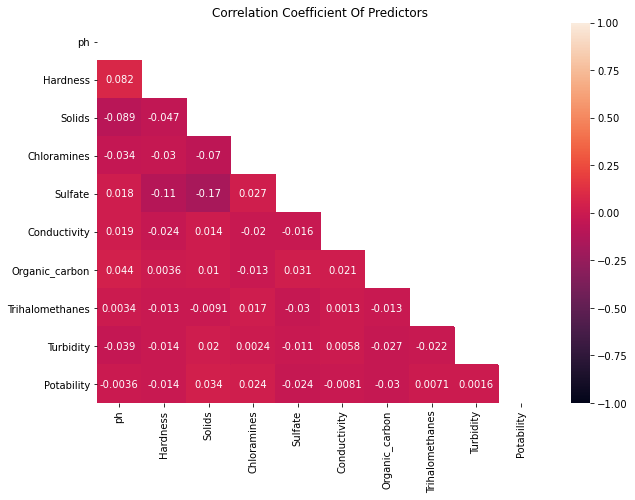

In [10]:
# check for correlation
# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

<p>Observation: There doesn't seem to be any co-relation between features whcih is good thing as multicolinearity affects logistic regression model. So, the correlation analysis will not have effect on feature selection.<p>

In [11]:
# checking the value count on target feature
df.Potability.value_counts(normalize = True)

0    0.60989
1    0.39011
Name: Potability, dtype: float64

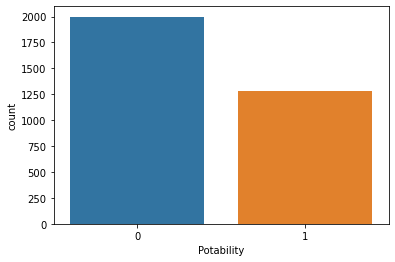

In [12]:
# visualizing the value count
ax=sns.countplot(x=df['Potability'])

<p>Observation: Potable water observations seem to be lower than non-potable ones. There is slight class imbalance. Since, imbalance is not high, we can opt for change in performance metric in our logistic model preferring f1 score and Precision over Accuracy.<p>

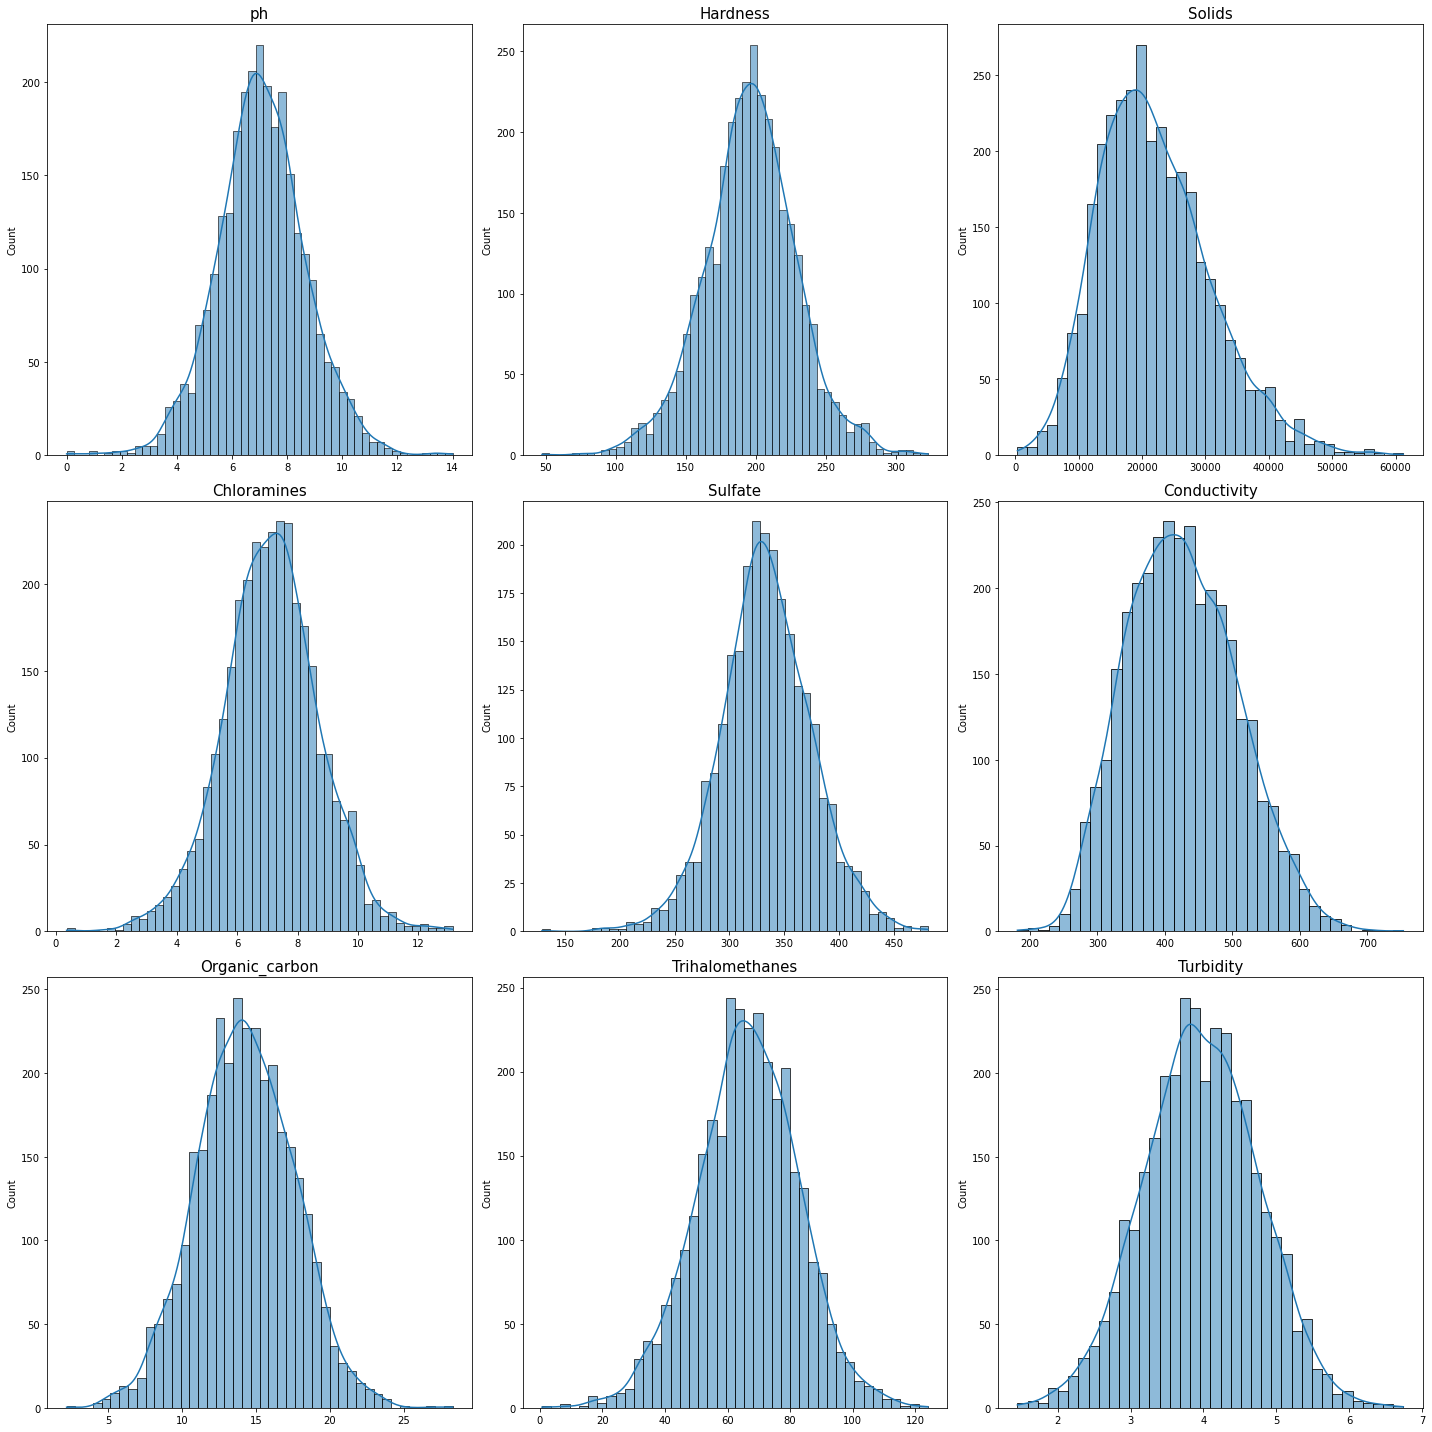

In [13]:
# checking for distributions of features
fig, axes = plt.subplots(3, 3, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    sns.histplot(x=df.iloc[:,i], kde=True, ax=ax)
    ax.set_title(df.columns[i], fontsize=15)
    ax.set_xlabel('')
fig.tight_layout()
plt.show()

<b style="font-size:1.2vw">Data-Preprocessing / Cleaning based on EDA<b>

<b>Null Values Treatment - replacing them with column median since it gets less affected by outliers<b>

In [14]:
df_null = df.copy(deep=True)
df_null['ph'] = df['ph'].fillna(df['ph'].median())
df_null['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].median())
df_null['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].median())

In [15]:
#checking 1st 5 rows again
df_null.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [16]:
#checking data stats after null values replacement
df_null.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.074194,196.369496,22014.092526,7.122277,333.608364,426.205111,14.284970,66.407478,3.966786,0.390110
std,1.470040,32.879761,8768.570828,1.583085,36.143851,80.824064,3.308162,15.769958,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


<b>Outliers Treatment<b>

<p>As boxplot analysis showed, most features lied outside the box, deeming outliers normal. So, the stratgy I adopted with outliers is that to just to loosely penalize the values that seems way to unlikely to occur and out of limits, but not more as to not risk data loss. So, I am applying Winsorizing as outlier detection and treatment technique. I will find the k-th percentile of each feature that is closest (with appropriate buffer as to not lose relevant data) to upper and lower limits calculated by Q3 +- 1.5*IQR formula, and replace the values exceeding this limit with value with that k-th percentile.<p>

Deciding on closest percentile to winsorize lower tail with for each feature

In [17]:
# features data
features = df_null.loc[:,df_null.columns != 'Potability']
Q1 = features.quantile(0.25)
Q3 = features.quantile(0.75)
IQR = Q3 - Q1
# respective lower limit for all features
Q1 - (1.5 * IQR)

ph                    3.889107
Hardness            117.125160
Solids            -1832.417449
Chloramines           3.146221
Sulfate             267.157960
Conductivity        191.647579
Organic_carbon        5.328026
Trihalomethanes      26.619225
Turbidity             1.848797
dtype: float64

Choose different quantiles at the lower end and find appropriate one to above limits for each feature

In [18]:
print('Winsorize percentile for lower limit of ph :',df_null['ph'].quantile(0.01),', 1%')
print('Winsorize percentile for lower limit of Hardness :',df_null['Hardness'].quantile(0.01),', 1%')
print('Winsorize percentile for lower limit of Solids : no winsorization required on left tail for solids, take winsorization lower level as zero')
print('Winsorize percentile for lower limit of Chloramines :',df_null['Chloramines'].quantile(0.01),', 1%')
print('Winsorize percentile for lower limit of Sulfate :',df_null['Sulfate'].quantile(0.03),', 3%')
print('Winsorize percentile for lower limit of Conductivity :',df_null['Conductivity'].quantile(0.001),', 0.1%')
print('Winsorize percentile for upper limit of Organic_carbon :',df_null['Organic_carbon'].quantile(0.005),', 99.5%')
print('Winsorize percentile for lower limit of Trihalomethanes :',df_null['Trihalomethanes'].quantile(0.01),', 1%')
print('Winsorize percentile for lower limit of Turbidity :',df_null['Turbidity'].quantile(0.005),', 0.5%')

Winsorize percentile for lower limit of ph : 3.4425103382835722 , 1%
Winsorize percentile for lower limit of Hardness : 114.23636579883768 , 1%
Winsorize percentile for lower limit of Solids : no winsorization required on left tail for solids, take winsorization lower level as zero
Winsorize percentile for lower limit of Chloramines : 3.2030819022911725 , 1%
Winsorize percentile for lower limit of Sulfate : 260.8452706109917 , 3%
Winsorize percentile for lower limit of Conductivity : 221.55353555162182 , 0.1%
Winsorize percentile for upper limit of Organic_carbon : 5.5485468771231155 , 99.5%
Winsorize percentile for lower limit of Trihalomethanes : 28.52499261378618 , 1%
Winsorize percentile for lower limit of Turbidity : 1.9627458047256539 , 0.5%


In [19]:
# respective upper limit for all features
Q3 + (1.5 * IQR) 

ph                    10.258615
Hardness             276.392834
Solids             44831.869873
Chloramines           11.096086
Sulfate              400.322434
Conductivity         655.879140
Organic_carbon        23.295427
Trihalomethanes      106.695040
Turbidity              6.091233
dtype: float64

Finalize different quantiles at the upper end and find closest one to above limits for each feature

In [20]:
print('Winsorize percentile for upper limit of ph :',df_null['ph'].quantile(0.975),', 97.5%')
print('Winsorize percentile for upper limit of Hardness :',df_null['Hardness'].quantile(0.98),', 99%')
print('Winsorize percentile for upper limit of Solids :',df_null['Solids'].quantile(0.985),', 98.5%')
print('Winsorize percentile for upper limit of Chloramines :',df_null['Chloramines'].quantile(0.96),', 96%')
print('Winsorize percentile for upper limit of Sulfate :',df_null['Sulfate'].quantile(0.96),', 96%')
print('Winsorize percentile for upper limit of Conductivity :',df_null['Conductivity'].quantile(0.995),', 99.5%')
print('Winsorize percentile for upper limit of Organic_carbon :',df_null['Organic_carbon'].quantile(0.995),', 99.5%')
print('Winsorize percentile for upper limit of Trihalomethanes :',df_null['Trihalomethanes'].quantile(0.995),', 99.5%')
print('Winsorize percentile for upper limit of Turbidity :',df_null['Turbidity'].quantile(0.999),', 99.9%')

Winsorize percentile for upper limit of ph : 10.20074216427455 , 97.5%
Winsorize percentile for upper limit of Hardness : 269.14689722702485 , 99%
Winsorize percentile for upper limit of Solids : 44580.928360034144 , 98.5%
Winsorize percentile for upper limit of Chloramines : 9.86504750268218 , 96%
Winsorize percentile for upper limit of Sulfate : 400.8960233338551 , 96%
Winsorize percentile for upper limit of Conductivity : 637.3467719872093 , 99.5%
Winsorize percentile for upper limit of Organic_carbon : 22.874330169738244 , 99.5%
Winsorize percentile for upper limit of Trihalomethanes : 108.24600972944091 , 99.5%
Winsorize percentile for upper limit of Turbidity : 6.380437324700421 , 99.9%


Winsorizing each feature data based above found respective suitable percentiles

In [21]:
df_win = df_null.copy(deep=True)
df_win['ph'] = winsorize(df_null['ph'], limits=(0.01, (1-0.975)))
df_win['Hardness'] = winsorize(df_null['Hardness'], limits=(0.01, (1-0.99)))
df_win['Solids'] = winsorize(df_null['Solids'], limits=(0, (1-0.985)))
df_win['Chloramines'] = winsorize(df_null['Chloramines'], limits=(0.01, (1-0.995)))
df_win['Sulfate'] = winsorize(df_null['Sulfate'], limits=(0.03, (1-0.96)))
df_win['Conductivity'] = winsorize(df_null['Conductivity'], limits=(0.001, (1-0.995)))
df_win['Organic_carbon'] = winsorize(df_null['Organic_carbon'], limits=(0.005, (1-0.995)))
df_win['Trihalomethanes'] = winsorize(df_null['Trihalomethanes'], limits=(0.01, (1-0.995)))
df_win['Turbidity'] = winsorize(df_null['Turbidity'], limits=(0.005, (1-0.999)))

In [22]:
df_win.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.065620,196.373239,21953.568494,7.125208,333.421429,426.074468,14.282612,66.458636,3.967638,0.390110
std,1.394441,32.159484,8583.428890,1.550893,32.302164,80.331573,3.281125,15.472794,0.776965,0.487849
min,3.434856,113.831112,320.942611,3.194969,260.771026,217.358330,5.537059,28.400877,1.961475,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,10.201426,278.081446,44586.812651,11.543190,400.896023,638.000182,22.891011,108.265227,6.389161,1.000000


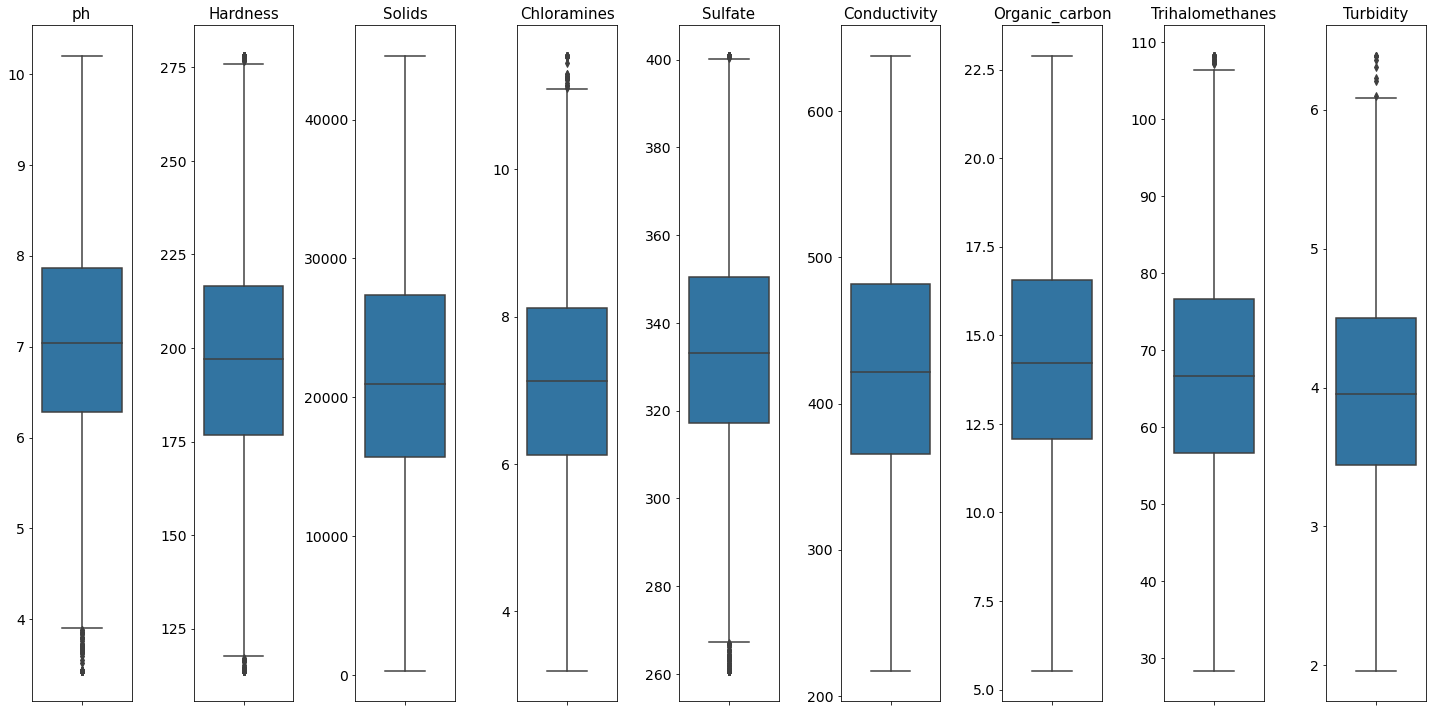

In [23]:
# checking for outliers again
fig, axs = plt.subplots(1, len(df_win.columns)-1, figsize=(20,10))
for i, ax in enumerate(axs.flat): 
    sns.boxplot(y=df_win.iloc[:,i], ax=ax)
    ax.set_title(df_win.columns[i], fontsize=15)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('')
    
plt.tight_layout()

Observation: Outliers are excluded now for most of the features and for other 'normal' outliers are kept in the data.

<b>Feature Engineering: Standardization<b>

All independent variables in given dataset are numerial and continuous and they have Gaussian Distribution (Bell Curve). They all have values varying between different scales. Hence, going with Standardization (Z-score normalization) here to bring all of them in same range and avoid bias<b>

In [24]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_win.loc[:,df_win.columns != 'Potability'])

In [25]:
# check the mean and standard deviation values should be approximately 0 and 1 respectively
print(data_scaled.mean(axis=0))
print(data_scaled.std(axis=0))

[-5.28135397e-16  1.75683643e-16 -8.13350201e-17 -1.09531160e-16
  9.54330903e-16  5.09699459e-17 -1.62670040e-17  4.25111038e-16
  7.69971524e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [26]:
df_scaled = pd.DataFrame(data_scaled,columns=df_win.columns[:-1])
df_scaled['Potability'] = df_win['Potability']

In [27]:
df_scaled.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3276.000000
mean,-6.036075e-16,1.276007e-16,-9.384028e-17,-8.557969e-17,1.043921e-15,6.066237e-17,-1.338639e-17,4.775721e-16,7.786473e-16,0.390110
std,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,0.487849
min,-2.604139e+00,-2.567041e+00,-2.520663e+00,-2.534565e+00,-2.249431e+00,-2.598580e+00,-2.665820e+00,-2.460032e+00,-2.582445e+00,0.000000
25%,-5.651493e-01,-6.071516e-01,-7.325555e-01,-6.434612e-01,-5.055167e-01,-7.512521e-01,-6.757283e-01,-6.341762e-01,-6.795776e-01,0.000000
50%,-2.070501e-02,1.848534e-02,-1.195200e-01,3.283055e-03,-1.077132e-02,-5.216055e-02,-1.959212e-02,1.059112e-02,-1.623311e-02,0.000000
75%,5.769717e-01,6.311456e-01,6.267909e-01,6.382322e-01,5.252563e-01,6.937041e-01,6.934775e-01,6.598376e-01,6.856976e-01,1.000000
max,2.249134e+00,2.541107e+00,2.637256e+00,2.849104e+00,2.089176e+00,2.638540e+00,2.624012e+00,2.702354e+00,3.117120e+00,1.000000


In [28]:
df_scaled.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,-0.020705,0.264884,-0.135427,0.112858,1.086626,1.721058,-1.189660,1.327199,-1.293052,0
1,-2.402433,-2.082140,-0.387260,-0.315971,-0.010771,2.076847,0.273546,-0.654769,0.686131,0
2,0.741274,0.866534,-0.238173,1.386945,-0.010771,-0.092982,0.788272,-0.002491,-1.173597,0
3,0.897376,0.559801,0.007556,0.602406,0.726524,-0.781978,1.266196,2.190181,0.851047,0
4,1.453567,-0.474947,-0.463124,-0.373138,-0.720981,-0.344421,-0.830431,-2.227517,0.138299,0


In [29]:
df_scaled.shape

(3276, 10)

<b style="font-size:1.2vw">Model Building<b>

<b>Data Splitting: Train - Validation - Test<b>

In [30]:
# features data
X = df_scaled.iloc[:,:-1].values
# target var data
Y = df_scaled.iloc[:,-1:].values

In [31]:
X.shape

(3276, 9)

In [32]:
Y.shape

(3276, 1)

Since we do not have large data, keeping training data as 70%, the same ratio I also finalized after experimenting with split ratio & judging the split based on training error

In [67]:
# set aside 10% of data for evaluation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 4)

In [68]:
print("X_train shape: ",X_train.shape)
print("Y_train shape: ",Y_train.shape)
print("X_test shape: ",X_test.shape)
print("Y_test shape: ",Y_test.shape)

X_train shape:  (2293, 9)
Y_train shape:  (2293, 1)
X_test shape:  (983, 9)
Y_test shape:  (983, 1)


<b>Hyperparameters tuning: Using GridSearchCV on training data set to get best parameters<b>

In [69]:
model = LogisticRegression()
solvers = ['liblinear']
penalty = ['l2', 'l1']
c_values = [1,0.5,0.1,0.01,0.003]
grid = dict(solver=solvers, penalty=penalty, C=c_values)
# use f1 score as performace metric as we have imbalanced data
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring= 'f1', error_score=0, return_train_score=True)

In [70]:
# Fit the model to training data
grid_result = grid_search.fit(X_train, Y_train.ravel())

Find best parameters based on f1-score as metric as we have imbalanced data

In [71]:
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.052595 using {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

0.052595 (0.025501) with: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.048763 (0.021015) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.052595 (0.025501) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
0.040565 (0.014959) with: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
0.052595 (0.025501) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.019602 (0.010623) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.050618 (0.023440) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.044334 (0.023523) with: {'C': 0.003, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.003, 'penalty': 'l1', 'solver': 'liblinear'}


<b>Use above optimal hyperparameters {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} to fit on train data and predict on test data<b>

In [72]:
logisticModel = LogisticRegression(penalty='l2', C=1, solver='liblinear')
logisticModel.fit( X_train, Y_train.ravel())
Y_test_pred = logisticModel.predict( X_test )
print('Accuracy score on Test set:',accuracy_score(Y_test,Y_test_pred))
print('Precision score on Test set:',precision_score(Y_test,Y_test_pred))
print('F1 score on Test set:',f1_score(Y_test,Y_test_pred))
print('Recall score on Test set:',recall_score(Y_test,Y_test_pred))

Accuracy score on Test set: 0.6205493387589013
Precision score on Test set: 0.6111111111111112
F1 score on Test set: 0.055696202531645575
Recall score on Test set: 0.029177718832891247


In [73]:
# compare test & train score & check for underfittig or overfitting
Y_train_pred = logisticModel.predict(X_train)
train_score = accuracy_score(Y_train, Y_train_pred)
# evaluate on the test dataset
test_score = accuracy_score(Y_test, Y_test_pred)
print(train_score,test_score)

0.6140427387701701 0.6205493387589013


As we can see train & test scores are very near to each other indicating that our model is not overfitted or underfitted

Plot Confusion Marix

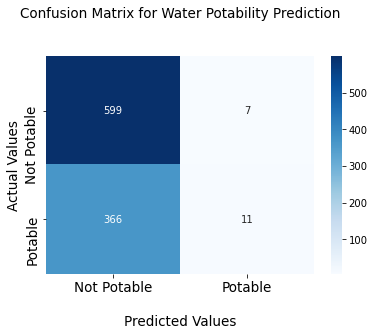

In [74]:
cm = confusion_matrix(Y_test,Y_test_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix for Water Potability Prediction\n\n', fontdict={'size':'13.5'})
ax.set_xlabel('\nPredicted Values', fontdict={'size':'13.5'})
ax.set_ylabel('Actual Values', fontdict={'size':'13.5'})
ax.xaxis.set_ticklabels(['Not Potable','Potable'])
ax.yaxis.set_ticklabels(['Not Potable','Potable'])
ax.tick_params(axis='both', which='major', labelsize=13.5)
plt.show()

Observation: 
- True Negatives being high is good thing as we don't want lot of Unpotable water samples to be deemed as Potable by the model.
- Number of true negatives & false negatives are quite high which is inline with class imbalance in the data leaning 60% towards negative class, which we tried to overcome with using f1-score as performace metrics .
- False positives are low which makes the model less susceptible of classifying not drinkable water as drinkable.